In [9]:
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Import and rearrange data

In [10]:
# Load data
bkgd = pd.read_hdf("data/preprocessed/bkgd.h5", key="bkgd")
vlq = pd.read_hdf("data/preprocessed/vlq.h5", key="vlq")
X_train = pd.concat([bkgd, vlq])
del bkgd, vlq

In [11]:
# Train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_train.drop(["Label"], axis=1), X_train["Label"], 
                                                    test_size=1/3, random_state=56)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=60)

In [12]:
# Save train data
X_train.to_hdf("data/classifier/train.h5", key="X")
y_train.to_hdf("data/classifier/train.h5", key="y")

# Save validation data
X_val.to_hdf("data/classifier/validation.h5", key="X")
y_val.to_hdf("data/classifier/validation.h5", key="y")

# Save test data
X_test.to_hdf("data/classifier/test.h5", key="X")
y_test.to_hdf("data/classifier/test.h5", key="y")

In [13]:
# Get data samples
train_samples, val_samples, test_samples = X_train["Sample"], X_val["Sample"], X_test["Sample"]

# Get data weights
train_weights, val_weights, test_weights = X_train["gen_weights"], X_val["gen_weights"], X_test["gen_weights"]

# Remove sample and weight columns
X_train.drop(["Sample", "gen_weights"], axis=1, inplace=True)
X_val.drop(["Sample", "gen_weights"], axis=1, inplace=True)
X_test.drop(["Sample", "gen_weights"], axis=1, inplace=True)

# Calculate class weights
class_weights = {
    0: 1,
    1: len(y_train[y_train==0]) / len(y_train[y_train==1])
}

# Create model

In [14]:
def get_model(hidden_layers=[100, 100, 100], dropout=0.1, batch_norm=True, optimizer="Nadam", summary=True):
    """
    This function creates a keras model, given the desired hidden_layers, dropout rate
    and optimizer of choice
    
    hidden_layers -> [int]: size of each desired hidden layer
    dropout -> float: desired dropout rate
    optimizer -> string: optimizer you choose to utilize
    
    returns a keras model
    """
    
    # Generate model structure
    inputs = keras.Input(shape=(69,))
    bn = keras.layers.BatchNormalization()(inputs)
    drop = bn
    for i in range(len(hidden_layers)-1):
        fc = keras.layers.Dense(hidden_layers[i], activation='relu')(drop)
        if batch_norm:
            bn = keras.layers.BatchNormalization()(fc)
        else:
            bn = fc
        drop = keras.layers.Dropout(dropout)(bn, training=True)
    fc = keras.layers.Dense(hidden_layers[-1], activation='relu')(drop)
    outputs = keras.layers.Dense(1, activation='sigmoid')(fc)
    
    # Instanciate and compile model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss="binary_crossentropy",
                  metrics=["accuracy", keras.metrics.AUC()])
    if summary: model.summary()
    
    return model

# Optuna Bayesian Hyperparameter Search Function

In [15]:
def objective(trial):
    """
    Optuna objective function for bayesian inference hyperparameter search
    
    trial -> optuna trial object
    
    return -> float: validation accuracy of the best model with early stopping and model checkpoint
    """
    
    # Defining parameters
    num_layers = trial.suggest_int("num_hidden_layers", 1, 4)
    hidden_layers = []
    for i in range(num_layers):
        num_features = trial.suggest_int(f"num_features_layer_{i}", 20, 150)
        hidden_layers.append(num_features)
    dropout = trial.suggest_discrete_uniform("dropout", 0.05, 0.4, 0.01)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])
    batch_norm = trial.suggest_categorical("batch_norm", [True, False])
    optimizer = "Adam"
    es_patience = 10
    
    # Create model
    model = get_model(hidden_layers, dropout, batch_norm, optimizer)
    name = f"trial_{trial.number}"
    
    # Callbacks
    TB = keras.callbacks.TensorBoard("logs/" + name, write_images=True)
    ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=es_patience, mode="min")
    MC = keras.callbacks.ModelCheckpoint("models/" + name + ".h5", save_best_only=True, 
                                         monitor="val_loss", mode="min")
    LR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=es_patience, 
                                           mode="min", min_lr=1e-6)
    
    # Train
    history = model.fit(X_train.values, y_train.values, batch_size=batch_size, epochs=500, callbacks=[TB, ES, MC, LR],
                        validation_data=(X_val.values, y_val.values, val_weights.values), shuffle=True,
                        sample_weight=train_weights.values, class_weight=class_weights, verbose=2)
    
    return history.history["val_accuracy"][-es_patience-1]

In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 69)                276       
_________________________________________________________________
dense_17 (Dense)             (None, 122)               8540      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 123       
Total params: 8,939
Trainable params: 8,801
Non-trainable params: 138
_________________________________________________________________
Epoch 1/500
539/539 - 13s - loss: 1.0740e-05 - accuracy: 0.8035 - auc_4: 0.9454 - val_loss: 9.4869e-07 - val_accuracy: 0.7707 - val_auc_4: 0.9733
Epoch 2/500
539/539 - 1s - loss: 1.3417e-06 - accuracy: 0.7939 - auc_4: 0.9714 - val_loss: 7.1461e-07 

[I 2020-08-13 12:08:58,742] Trial 0 finished with value: 0.8591586351394653 and parameters: {'num_hidden_layers': 1, 'num_features_layer_0': 122, 'dropout': 0.3, 'batch_size': 512, 'batch_norm': True}. Best is trial 0 with value: 0.8591586351394653.


Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 69)                276       
_________________________________________________________________
dense_19 (Dense)             (None, 67)                4690      
_________________________________________________________________
batch_normalization_9 (Batch (None, 67)                268       
_________________________________________________________________
dropout_9 (Dropout)          (None, 67)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 62)                4216      
_________________________________________________________________
batch_normalization_10 (Batc (None, 62)              

[I 2020-08-13 12:10:01,048] Trial 1 finished with value: 0.8878909349441528 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 67, 'num_features_layer_1': 62, 'num_features_layer_2': 108, 'dropout': 0.1, 'batch_size': 512, 'batch_norm': True}. Best is trial 1 with value: 0.8878909349441528.


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 69)                276       
_________________________________________________________________
dense_23 (Dense)             (None, 146)               10220     
_________________________________________________________________
dropout_11 (Dropout)         (None, 146)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 90)                13230     
_________________________________________________________________
dropout_12 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 50)              

[I 2020-08-13 12:10:55,437] Trial 2 finished with value: 0.8564112186431885 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 146, 'num_features_layer_1': 90, 'num_features_layer_2': 50, 'dropout': 0.22999999999999998, 'batch_size': 512, 'batch_norm': False}. Best is trial 1 with value: 0.8878909349441528.


Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 69)                276       
_________________________________________________________________
dense_27 (Dense)             (None, 78)                5460      
_________________________________________________________________
dropout_13 (Dropout)         (None, 78)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 31)                2449      
_________________________________________________________________
dropout_14 (Dropout)         (None, 31)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 20)              

[I 2020-08-13 12:12:51,315] Trial 3 finished with value: 0.8920555710792542 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 78, 'num_features_layer_1': 31, 'num_features_layer_2': 20, 'num_features_layer_3': 61, 'dropout': 0.33999999999999997, 'batch_size': 128, 'batch_norm': False}. Best is trial 3 with value: 0.8920555710792542.


Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 69)                276       
_________________________________________________________________
dense_32 (Dense)             (None, 35)                2450      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 36        
Total params: 2,762
Trainable params: 2,624
Non-trainable params: 138
_________________________________________________________________
Epoch 1/500
539/539 - 13s - loss: 1.8653e-05 - accuracy: 0.8270 - auc_8: 0.9354 - val_loss: 1.6211e-06 - val_accuracy: 0.7713 - val_auc_8: 0.9661
Epoch 2/500
539/539 - 1s - loss: 1.6789e-06 - accuracy: 0.7721 - auc_8: 0.9641 - val_loss: 8.8080e-07

[I 2020-08-13 12:13:33,646] Trial 4 finished with value: 0.8614240288734436 and parameters: {'num_hidden_layers': 1, 'num_features_layer_0': 35, 'dropout': 0.31, 'batch_size': 512, 'batch_norm': True}. Best is trial 3 with value: 0.8920555710792542.


Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 69)                276       
_________________________________________________________________
dense_34 (Dense)             (None, 138)               9660      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 139       
Total params: 10,075
Trainable params: 9,937
Non-trainable params: 138
_________________________________________________________________
Epoch 1/500
2156/2156 - 15s - loss: 5.9052e-06 - accuracy: 0.8190 - auc_9: 0.9504 - val_loss: 6.2072e-07 - val_accuracy: 0.8298 - val_auc_9: 0.9631
Epoch 2/500
2156/2156 - 3s - loss: 1.0567e-06 - accuracy: 0.8481 - auc_9: 0.9605 - val_loss: 6.233

[I 2020-08-13 12:14:38,701] Trial 5 finished with value: 0.8792027235031128 and parameters: {'num_hidden_layers': 1, 'num_features_layer_0': 138, 'dropout': 0.2, 'batch_size': 128, 'batch_norm': True}. Best is trial 3 with value: 0.8920555710792542.


Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 69)                276       
_________________________________________________________________
dense_36 (Dense)             (None, 84)                5880      
_________________________________________________________________
dropout_16 (Dropout)         (None, 84)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 49)                4165      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 50        
Total params: 10,371
Trainable params: 10,233
Non-trainable params: 138
_______________________________________________

[I 2020-08-13 12:15:38,877] Trial 6 finished with value: 0.8997470140457153 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 84, 'num_features_layer_1': 49, 'dropout': 0.05, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 69)                276       
_________________________________________________________________
dense_39 (Dense)             (None, 97)                6790      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 98        
Total params: 7,164
Trainable params: 7,026
Non-trainable params: 138
_________________________________________________________________
Epoch 1/500
2156/2156 - 15s - loss: 5.0759e-06 - accuracy: 0.7860 - auc_11: 0.9463 - val_loss: 6.7501e-07 - val_accuracy: 0.8088 - val_auc_11: 0.9662
Epoch 2/500
2156/2156 - 3s - loss: 1.0862e-06 - accuracy: 0.8352 - auc_11: 0.9618 - val_loss: 8.6

[I 2020-08-13 12:16:45,526] Trial 7 finished with value: 0.8880141377449036 and parameters: {'num_hidden_layers': 1, 'num_features_layer_0': 97, 'dropout': 0.38, 'batch_size': 128, 'batch_norm': True}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 69)                276       
_________________________________________________________________
dense_41 (Dense)             (None, 72)                5040      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 73        
Total params: 5,389
Trainable params: 5,251
Non-trainable params: 138
_________________________________________________________________
Epoch 1/500
2156/2156 - 15s - loss: 7.3965e-06 - accuracy: 0.7915 - auc_12: 0.9417 - val_loss: 6.6131e-07 - val_accuracy: 0.8074 - val_auc_12: 0.9609
Epoch 2/500
2156/2156 - 3s - loss: 1.1186e-06 - accuracy: 0.8296 - auc_12: 0.9610 - val_loss: 5.5

[I 2020-08-13 12:17:44,784] Trial 8 finished with value: 0.8665818572044373 and parameters: {'num_hidden_layers': 1, 'num_features_layer_0': 72, 'dropout': 0.33, 'batch_size': 128, 'batch_norm': True}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 69)                276       
_________________________________________________________________
dense_43 (Dense)             (None, 97)                6790      
_________________________________________________________________
batch_normalization_19 (Batc (None, 97)                388       
_________________________________________________________________
dropout_17 (Dropout)         (None, 97)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 129)               12642     
_________________________________________________________________
batch_normalization_20 (Batc (None, 129)             

[I 2020-08-13 12:18:58,813] Trial 9 finished with value: 0.869445264339447 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 97, 'num_features_layer_1': 129, 'num_features_layer_2': 63, 'dropout': 0.29, 'batch_size': 512, 'batch_norm': True}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 69)                276       
_________________________________________________________________
dense_47 (Dense)             (None, 36)                2520      
_________________________________________________________________
dropout_19 (Dropout)         (None, 36)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 23)                851       
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 24        
Total params: 3,671
Trainable params: 3,533
Non-trainable params: 138
_________________________________________________

[I 2020-08-13 12:19:49,382] Trial 10 finished with value: 0.8718194365501404 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 36, 'num_features_layer_1': 23, 'dropout': 0.05, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 69)                276       
_________________________________________________________________
dense_50 (Dense)             (None, 61)                4270      
_________________________________________________________________
dropout_20 (Dropout)         (None, 61)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 20)                1240      
_________________________________________________________________
dropout_21 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 145)             

[I 2020-08-13 12:21:21,411] Trial 11 finished with value: 0.8982174396514893 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 61, 'num_features_layer_1': 20, 'num_features_layer_2': 145, 'num_features_layer_3': 62, 'dropout': 0.15000000000000002, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 69)                276       
_________________________________________________________________
dense_55 (Dense)             (None, 47)                3290      
_________________________________________________________________
dropout_23 (Dropout)         (None, 47)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 52)                2496      
_________________________________________________________________
dropout_24 (Dropout)         (None, 52)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 146)             

[I 2020-08-13 12:22:24,925] Trial 12 finished with value: 0.7758760452270508 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 47, 'num_features_layer_1': 52, 'num_features_layer_2': 146, 'num_features_layer_3': 121, 'dropout': 0.12000000000000001, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 69)                276       
_________________________________________________________________
dense_60 (Dense)             (None, 57)                3990      
_________________________________________________________________
dropout_26 (Dropout)         (None, 57)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 25)                1450      
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 26        
Total params: 5,742
Trainable params: 5,604
Non-trainable params: 138
_________________________________________________

[I 2020-08-13 12:23:15,708] Trial 13 finished with value: 0.852623462677002 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 57, 'num_features_layer_1': 25, 'dropout': 0.05, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 69)                276       
_________________________________________________________________
dense_63 (Dense)             (None, 21)                1470      
_________________________________________________________________
dropout_27 (Dropout)         (None, 21)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 58)                1276      
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 59        
Total params: 3,081
Trainable params: 2,943
Non-trainable params: 138
_________________________________________________

[I 2020-08-13 12:24:08,900] Trial 14 finished with value: 0.8561393618583679 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 21, 'num_features_layer_1': 58, 'dropout': 0.15000000000000002, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 69)                276       
_________________________________________________________________
dense_66 (Dense)             (None, 96)                6720      
_________________________________________________________________
dropout_28 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 91)                8827      
_________________________________________________________________
dropout_29 (Dropout)         (None, 91)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 145)             

[I 2020-08-13 12:25:18,979] Trial 15 finished with value: 0.8784089684486389 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 96, 'num_features_layer_1': 91, 'num_features_layer_2': 145, 'num_features_layer_3': 23, 'dropout': 0.19, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 69)                276       
_________________________________________________________________
dense_71 (Dense)             (None, 117)               8190      
_________________________________________________________________
dropout_31 (Dropout)         (None, 117)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 42)                4956      
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 43        
Total params: 13,465
Trainable params: 13,327
Non-trainable params: 138
_______________________________________________

[I 2020-08-13 12:26:09,492] Trial 16 finished with value: 0.8475925326347351 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 117, 'num_features_layer_1': 42, 'dropout': 0.09, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 69)                276       
_________________________________________________________________
dense_74 (Dense)             (None, 88)                6160      
_________________________________________________________________
dropout_32 (Dropout)         (None, 88)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 69)                6141      
_________________________________________________________________
dropout_33 (Dropout)         (None, 69)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 110)             

[I 2020-08-13 12:27:10,649] Trial 17 finished with value: 0.8594377636909485 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 88, 'num_features_layer_1': 69, 'num_features_layer_2': 110, 'dropout': 0.15000000000000002, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 69)                276       
_________________________________________________________________
dense_78 (Dense)             (None, 58)                4060      
_________________________________________________________________
dropout_34 (Dropout)         (None, 58)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 115)               6785      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 116       
Total params: 11,237
Trainable params: 11,099
Non-trainable params: 138
_______________________________________________

[I 2020-08-13 12:28:19,045] Trial 18 finished with value: 0.8729104399681091 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 58, 'num_features_layer_1': 115, 'dropout': 0.25, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 69)                276       
_________________________________________________________________
dense_81 (Dense)             (None, 115)               8050      
_________________________________________________________________
dropout_35 (Dropout)         (None, 115)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 39)                4524      
_________________________________________________________________
dropout_36 (Dropout)         (None, 39)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 117)             

[I 2020-08-13 12:29:18,186] Trial 19 finished with value: 0.862605631351471 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 115, 'num_features_layer_1': 39, 'num_features_layer_2': 117, 'dropout': 0.05, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 69)                276       
_________________________________________________________________
dense_85 (Dense)             (None, 20)                1400      
_________________________________________________________________
dropout_37 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_38 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 149)             

[I 2020-08-13 12:30:33,290] Trial 20 finished with value: 0.8519710898399353 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 20, 'num_features_layer_1': 20, 'num_features_layer_2': 149, 'num_features_layer_3': 70, 'dropout': 0.15000000000000002, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 69)                276       
_________________________________________________________________
dense_90 (Dense)             (None, 77)                5390      
_________________________________________________________________
dropout_40 (Dropout)         (None, 77)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 35)                2730      
_________________________________________________________________
dropout_41 (Dropout)         (None, 35)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 26)              

[I 2020-08-13 12:31:51,074] Trial 21 finished with value: 0.7636719942092896 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 77, 'num_features_layer_1': 35, 'num_features_layer_2': 26, 'num_features_layer_3': 55, 'dropout': 0.39, 'batch_size': 128, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 69)                276       
_________________________________________________________________
dense_95 (Dense)             (None, 79)                5530      
_________________________________________________________________
dropout_43 (Dropout)         (None, 79)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 23)                1840      
_________________________________________________________________
dropout_44 (Dropout)         (None, 23)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 24)              

[I 2020-08-13 12:33:32,246] Trial 22 finished with value: 0.8765386343002319 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 79, 'num_features_layer_1': 23, 'num_features_layer_2': 24, 'num_features_layer_3': 41, 'dropout': 0.36, 'batch_size': 128, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 69)                276       
_________________________________________________________________
dense_100 (Dense)            (None, 62)                4340      
_________________________________________________________________
dropout_46 (Dropout)         (None, 62)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 75)                4725      
_________________________________________________________________
dropout_47 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 83)              

[I 2020-08-13 12:35:46,604] Trial 23 finished with value: 0.8960825204849243 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 62, 'num_features_layer_1': 75, 'num_features_layer_2': 83, 'num_features_layer_3': 95, 'dropout': 0.26, 'batch_size': 128, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 69)                276       
_________________________________________________________________
dense_105 (Dense)            (None, 57)                3990      
_________________________________________________________________
dropout_49 (Dropout)         (None, 57)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 76)                4408      
_________________________________________________________________
dropout_50 (Dropout)         (None, 76)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 80)              

[I 2020-08-13 12:37:14,157] Trial 24 finished with value: 0.8691806793212891 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 57, 'num_features_layer_1': 76, 'num_features_layer_2': 80, 'dropout': 0.26, 'batch_size': 128, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 69)                276       
_________________________________________________________________
dense_109 (Dense)            (None, 42)                2940      
_________________________________________________________________
dropout_51 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 105)               4515      
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 106       
Total params: 7,837
Trainable params: 7,699
Non-trainable params: 138
_________________________________________________

[I 2020-08-13 12:38:16,841] Trial 25 finished with value: 0.8837226033210754 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 42, 'num_features_layer_1': 105, 'dropout': 0.19, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 69)                276       
_________________________________________________________________
dense_112 (Dense)            (None, 67)                4690      
_________________________________________________________________
dropout_52 (Dropout)         (None, 67)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 50)                3400      
_________________________________________________________________
dropout_53 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 90)              

[I 2020-08-13 12:39:42,619] Trial 26 finished with value: 0.8673756122589111 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 67, 'num_features_layer_1': 50, 'num_features_layer_2': 90, 'num_features_layer_3': 106, 'dropout': 0.27, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 69)                276       
_________________________________________________________________
dense_117 (Dense)            (None, 88)                6160      
_________________________________________________________________
dropout_55 (Dropout)         (None, 88)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 81)                7209      
_________________________________________________________________
dropout_56 (Dropout)         (None, 81)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 88)              

[I 2020-08-13 12:41:26,314] Trial 27 finished with value: 0.882305383682251 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 88, 'num_features_layer_1': 81, 'num_features_layer_2': 88, 'dropout': 0.21000000000000002, 'batch_size': 128, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 69)                276       
_________________________________________________________________
dense_121 (Dense)            (None, 53)                3710      
_________________________________________________________________
dropout_57 (Dropout)         (None, 53)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 150)               8100      
_________________________________________________________________
dropout_58 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 49)              

[I 2020-08-13 12:42:34,599] Trial 28 finished with value: 0.8508619070053101 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 53, 'num_features_layer_1': 150, 'num_features_layer_2': 49, 'num_features_layer_3': 86, 'dropout': 0.08, 'batch_size': 256, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 69)                276       
_________________________________________________________________
dense_126 (Dense)            (None, 64)                4480      
_________________________________________________________________
dropout_60 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 65)                4225      
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 66        
Total params: 9,047
Trainable params: 8,909
Non-trainable params: 138
_________________________________________________

[I 2020-08-13 12:43:56,654] Trial 29 finished with value: 0.8673104047775269 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 64, 'num_features_layer_1': 65, 'dropout': 0.16999999999999998, 'batch_size': 128, 'batch_norm': False}. Best is trial 6 with value: 0.8997470140457153.


# Save study dataframe

In [17]:
study_df = study.trials_dataframe().rename(columns={"number": "trial", "value": "val_acc"})
study_df.drop(["datetime_start", "datetime_complete"], axis=1, inplace=True)
study_df.to_hdf("optuna_studies/study_1.h5", key="study")
study_df

,trial,val_acc,duration,params_batch_norm,params_batch_size,params_dropout,params_num_features_layer_0,params_num_features_layer_1,params_num_features_layer_2,params_num_features_layer_3,params_num_hidden_layers,state
0,0,0.859159,0 days 00:00:39.880177,True,512,0.30,122,NaN,NaN,NaN,1,COMPLETE
1,1,0.887891,0 days 00:01:02.303350,True,512,0.10,67,62.0,108.0,NaN,3,COMPLETE
2,2,0.856411,0 days 00:00:54.387620,False,512,0.23,146,90.0,50.0,NaN,3,COMPLETE
3,3,0.892056,0 days 00:01:55.875590,False,128,0.34,78,31.0,20.0,61.0,4,COMPLETE
4,4,0.861424,0 days 00:00:42.329145,True,512,0.31,35,NaN,NaN,NaN,1,COMPLETE
5,5,0.879203,0 days 00:01:05.053292,True,128,0.20,138,NaN,NaN,NaN,1,COMPLETE
6,6,0.899747,0 days 00:01:00.173509,False,256,0.05,84,49.0,NaN,NaN,2,COMPLETE
7,7,0.888014,0 days 00:01:06.647167,True,128,0.38,97,NaN,NaN,NaN,1,COMPLETE
8,8,0.866582,0 days 00:00:59.257041,True,128,0.33,72,NaN,NaN,NaN,1,COMPLETE
9,9,0.869445,0 days 00:01:14.027203,True,512,0.29,97,129.0,63.0,NaN,3,COMPLETE


# Optuna Study Hyperparameter Plots

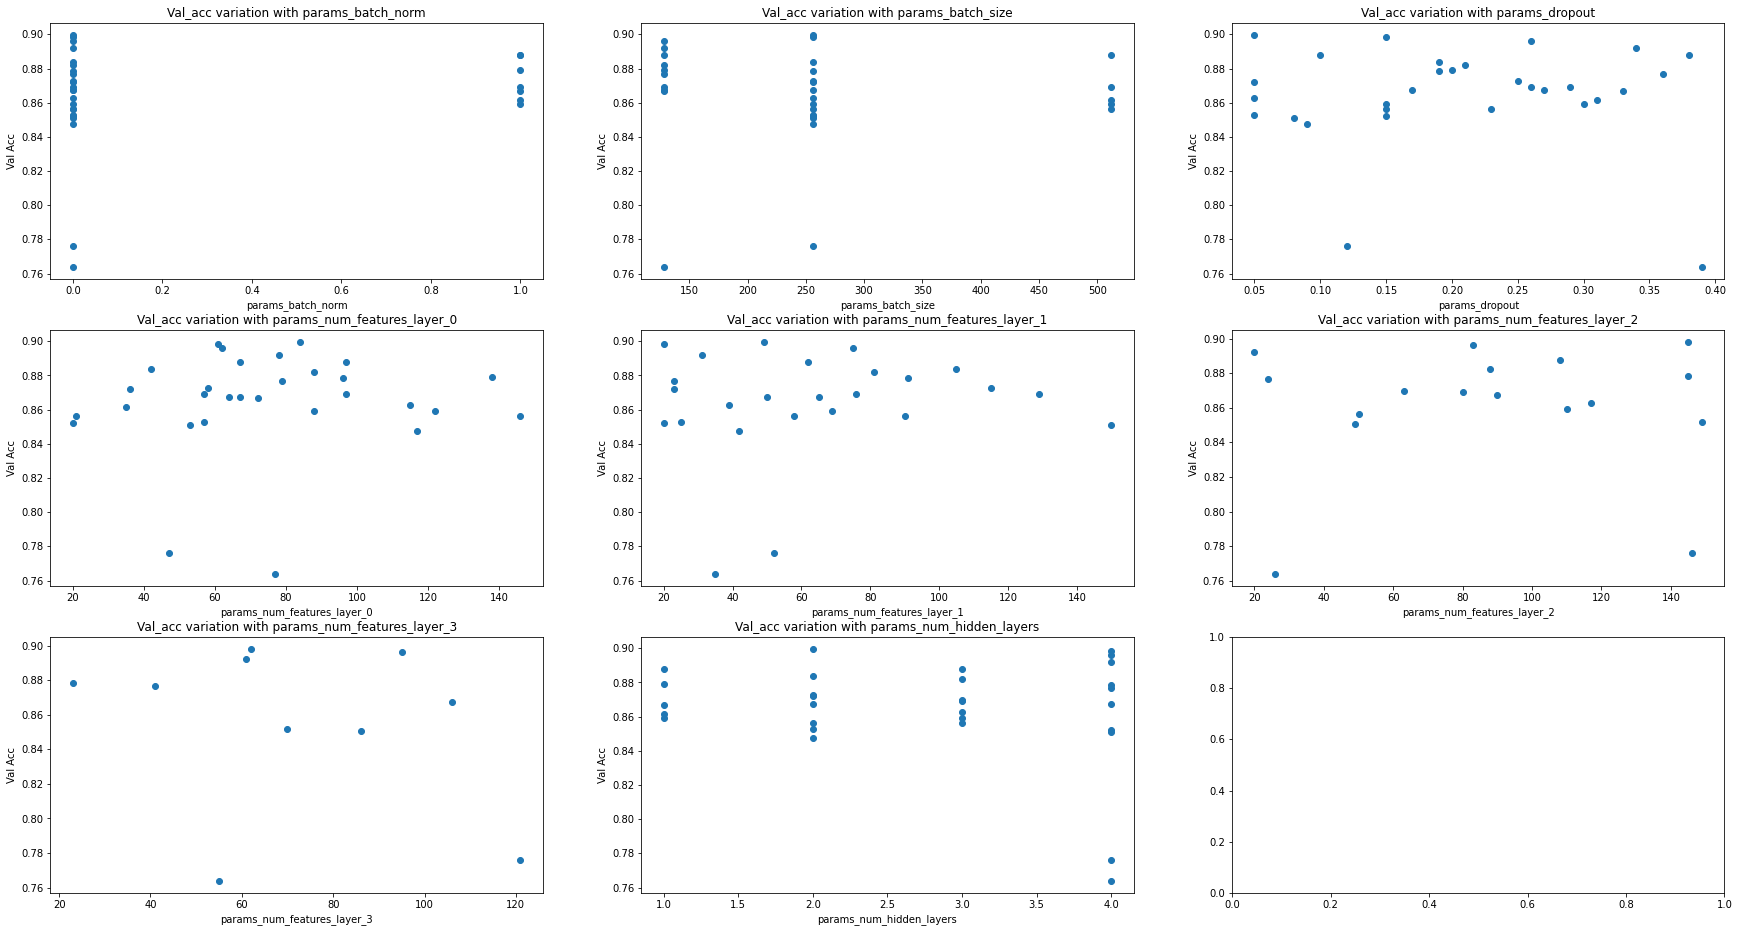

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(30, 16))

for i, column in enumerate(study_df.drop(["trial", "val_acc", "duration", "state"], axis=1)):
    row, col = i // 3, i % 3
    axs[row, col].set_title(f"Val_acc variation with {column}")
    axs[row, col].scatter(study_df[column].values, study_df["val_acc"].values)
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel("Val Acc")